In [1]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

In [11]:
# read images and steering angles from driving_dataset folder

from __future__ import division

import os
import numpy as np
import random

from scipy import pi
from itertools import islice



DATA_FOLDER = './driving_dataset/'  #Folder in which data is present 
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt') #Exact path from where data is to retrieve

LIMIT = None
split =0.8    #80% of data is train-dataset,20% of data is test-dataset 
X = []
y = []
with open(TRAIN_FILE) as fp: #opening the file 
    for line in islice(fp, LIMIT):  
        path, angle = line.strip().split()  #split data into path & angle (of each image)
        full_path = os.path.join(DATA_FOLDER, path)  #storing path in X 
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )          #storing path in Y


y = np.array(y)   #converting list into Array 
print("Completed processing data.txt")

split_index = int(len(y)*0.8)   #parameter which decided uptu where train-dataset is there 

train_y = y[:split_index]   #taking first 80% data 
test_y = y[split_index:]    #taking next 20% data 

          

Completed processing data.txt


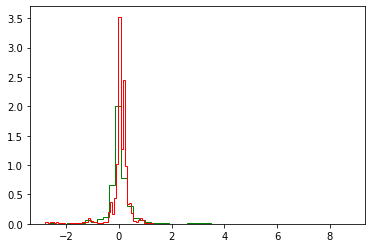

In [9]:
import numpy;

# PDF of train and test 'y' values. 
#Drawing histogram of angles present in both train-dataset & test-dataset 
import matplotlib.pyplot as plt 
plt.hist(train_y, bins=50, density=True, color='green', histtype ='step');
plt.hist(test_y, bins=50, density=True, color='red', histtype ='step');
plt.show()




In [12]:
#From above diagram we can see that Train & Test angles are not overlapping 
#yes it can happen bcoz data may varies as we move forward 

#Both in test & train have very often angle zero or around zero radian bcoz often roads are straights paractically 

#we have converted Angle from degree to radians bcoz if we have data in degree form then angle range will increse more 
#ex: -180 t0 +180 

In [13]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_y)   

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


Test_MSE(MEAN):0.191127
Test_MSE(ZERO):0.190891


In [ ]:
#If y_i_hat = Mean of train angles   (y_i_hat = predicted angles)
#MSE(Mean Square Error)= 0.19 

#If y_i_hat = 0  (y_i_hat = predicted angles)
#MSE(Mean Square Error)= 0.19 

#We have same results in both cases,it is bcoz train data-set is zero-centric 

#We uses MSE bcoz above problem is regression problem(Input: Images ,Output : Angles which is a real Number )


In [2]:
import scipy.misc
import random

#Created two lists  
xs = []   #Input 
ys = []   #Output 

#Pointers which points to the end of the previous  batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:   #open path from where we have to load data
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])  #store each image with its path 
        
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        
        ys.append(float(line.split()[1]) * scipy.pi / 180) #Store angle in radians 

#get number of images
num_images = len(xs)

#Spliting Data-set into Train & Test 
train_xs = xs[:int(len(xs) * 0.8)]
train_ys = ys[:int(len(xs) * 0.8)]

val_xs = xs[-int(len(xs) * 0.2):]
val_ys = ys[-int(len(xs) * 0.2):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

#We pass one  whole batch in one iteration
#train_batch_pointer points at last of that Batch 
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i)  
                                                % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out


In [4]:
import tensorflow as tf
import scipy

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output
